## Visualizing the ISS Ground Track with SatelliteToolbox.jl
### Introduction
Tracking satellites like the International Space Station (ISS) has become increasingly accessible thanks to powerful Julia packages like SatelliteToolbox.jl. This article demonstrates how to compute and visualize the ISS ground track and determine optimal observation times from specific locations.

---
### Part 1: Basic Ground Track Visualization
#### Obtaining Orbital Data

In [61]:
using SatelliteAnalysis

f=create_tle_fetcher(CelestrakTleFetcher)
tles=fetch_tles(f; satellite_name="ISS (ZARYA)")
iss_tle=first(tles)

[ Info: Fetch TLEs from Celestrak using satellite name: "ISS (ZARYA)" ...


TLE:
                      Name : ISS (ZARYA)
          Satellite number : 25544
  International designator : 98067A
        Epoch (Year / Day) : 25 / 196.17429620 (2025-07-15T04:10:59.192)
        Element set number : 999
              Eccentricity :   0.00027000
               Inclination :  51.63440000 deg
                      RAAN : 168.34110000 deg
       Argument of perigee :  13.11820000 deg
              Mean anomaly : 346.98770000 deg
           Mean motion (n) :  15.50554616 revs / day
         Revolution number : 51950
                        B* :   0.00016747 1 / er
                     ṅ / 2 :    9.301e-05 rev / day²
                     n̈ / 6 :            0 rev / day³

### 
This code retrieves the latest Two-Line Element (TLE) data for the ISS from Celestrak. TLEs

contain the orbital elements needed to calculate a satellite's position.

###
#### Orbit Propagation

In [62]:
# Create an orbit propagator by using the SGP4 algorithm
orbp=Propagators.init(Val(:SGP4), iss_tle)

OrbitPropagatorSgp4{Float64, Float64}:
   Propagator name : SGP4 Orbit Propagator
  Propagator epoch : 2025-07-15T04:10:59.192
  Last propagation : 2025-07-15T04:10:59.192

###
#### Computing Ground Tracks

In [63]:
# Compute the ground track during 2 days using the function ground_track
gt_asc=ground_track(orbp; duration=2*86400, track_types=:ascending)
# gt_des=ground_track(orbp; duration=2*86400, track_types=:descending)

5637-element Vector{Tuple{Float64, Float64}}:
 (3.848932633134229e-6, 3.007587002096087)
 (0.013778822641284485, 3.01728823734483)
 (0.02755255111903579, 3.0269938812579795)
 (0.041323340869888314, 3.0367080059206346)
 (0.05508949372163783, 3.046434683650752)
 (0.06884930470940975, 3.056177999950588)
 (0.08260105994436305, 3.0659420665075796)
 (0.09634303446277988, 3.075731007787648)
 (0.11007349005084645, 3.0855489740517403)
 (0.12379067304029749, 3.09540015433801)
 (0.13749281207018502, 3.1052887630817976)
 (0.15117811580989962, 3.1152190531595623)
 (0.16484477063869352, 3.1251953288978953)
 ⋮
 (-0.0016517390852294163, 2.812002816124742)
 (0.012123345124031166, 2.8217038493366133)
 (0.025897403269863617, 2.8314088212749784)
 (0.039668742315002475, 2.841121794566959)
 (0.05343566478268536, 2.8508468404207195)
 (0.06719646664114257, 2.8605880515331803)
 (0.08094943517444955, 2.8703495257892246)
 (0.0946928468335494, 2.8801353939200833)
 (0.1084249650639944, 2.8899498031311532)
 (0.1221

### 
This calculates the ISS's ground track (latitude/longitude points) for 2 days, separating

ascending (northbound) and descending (southbound) passes.

###
#### Visualization

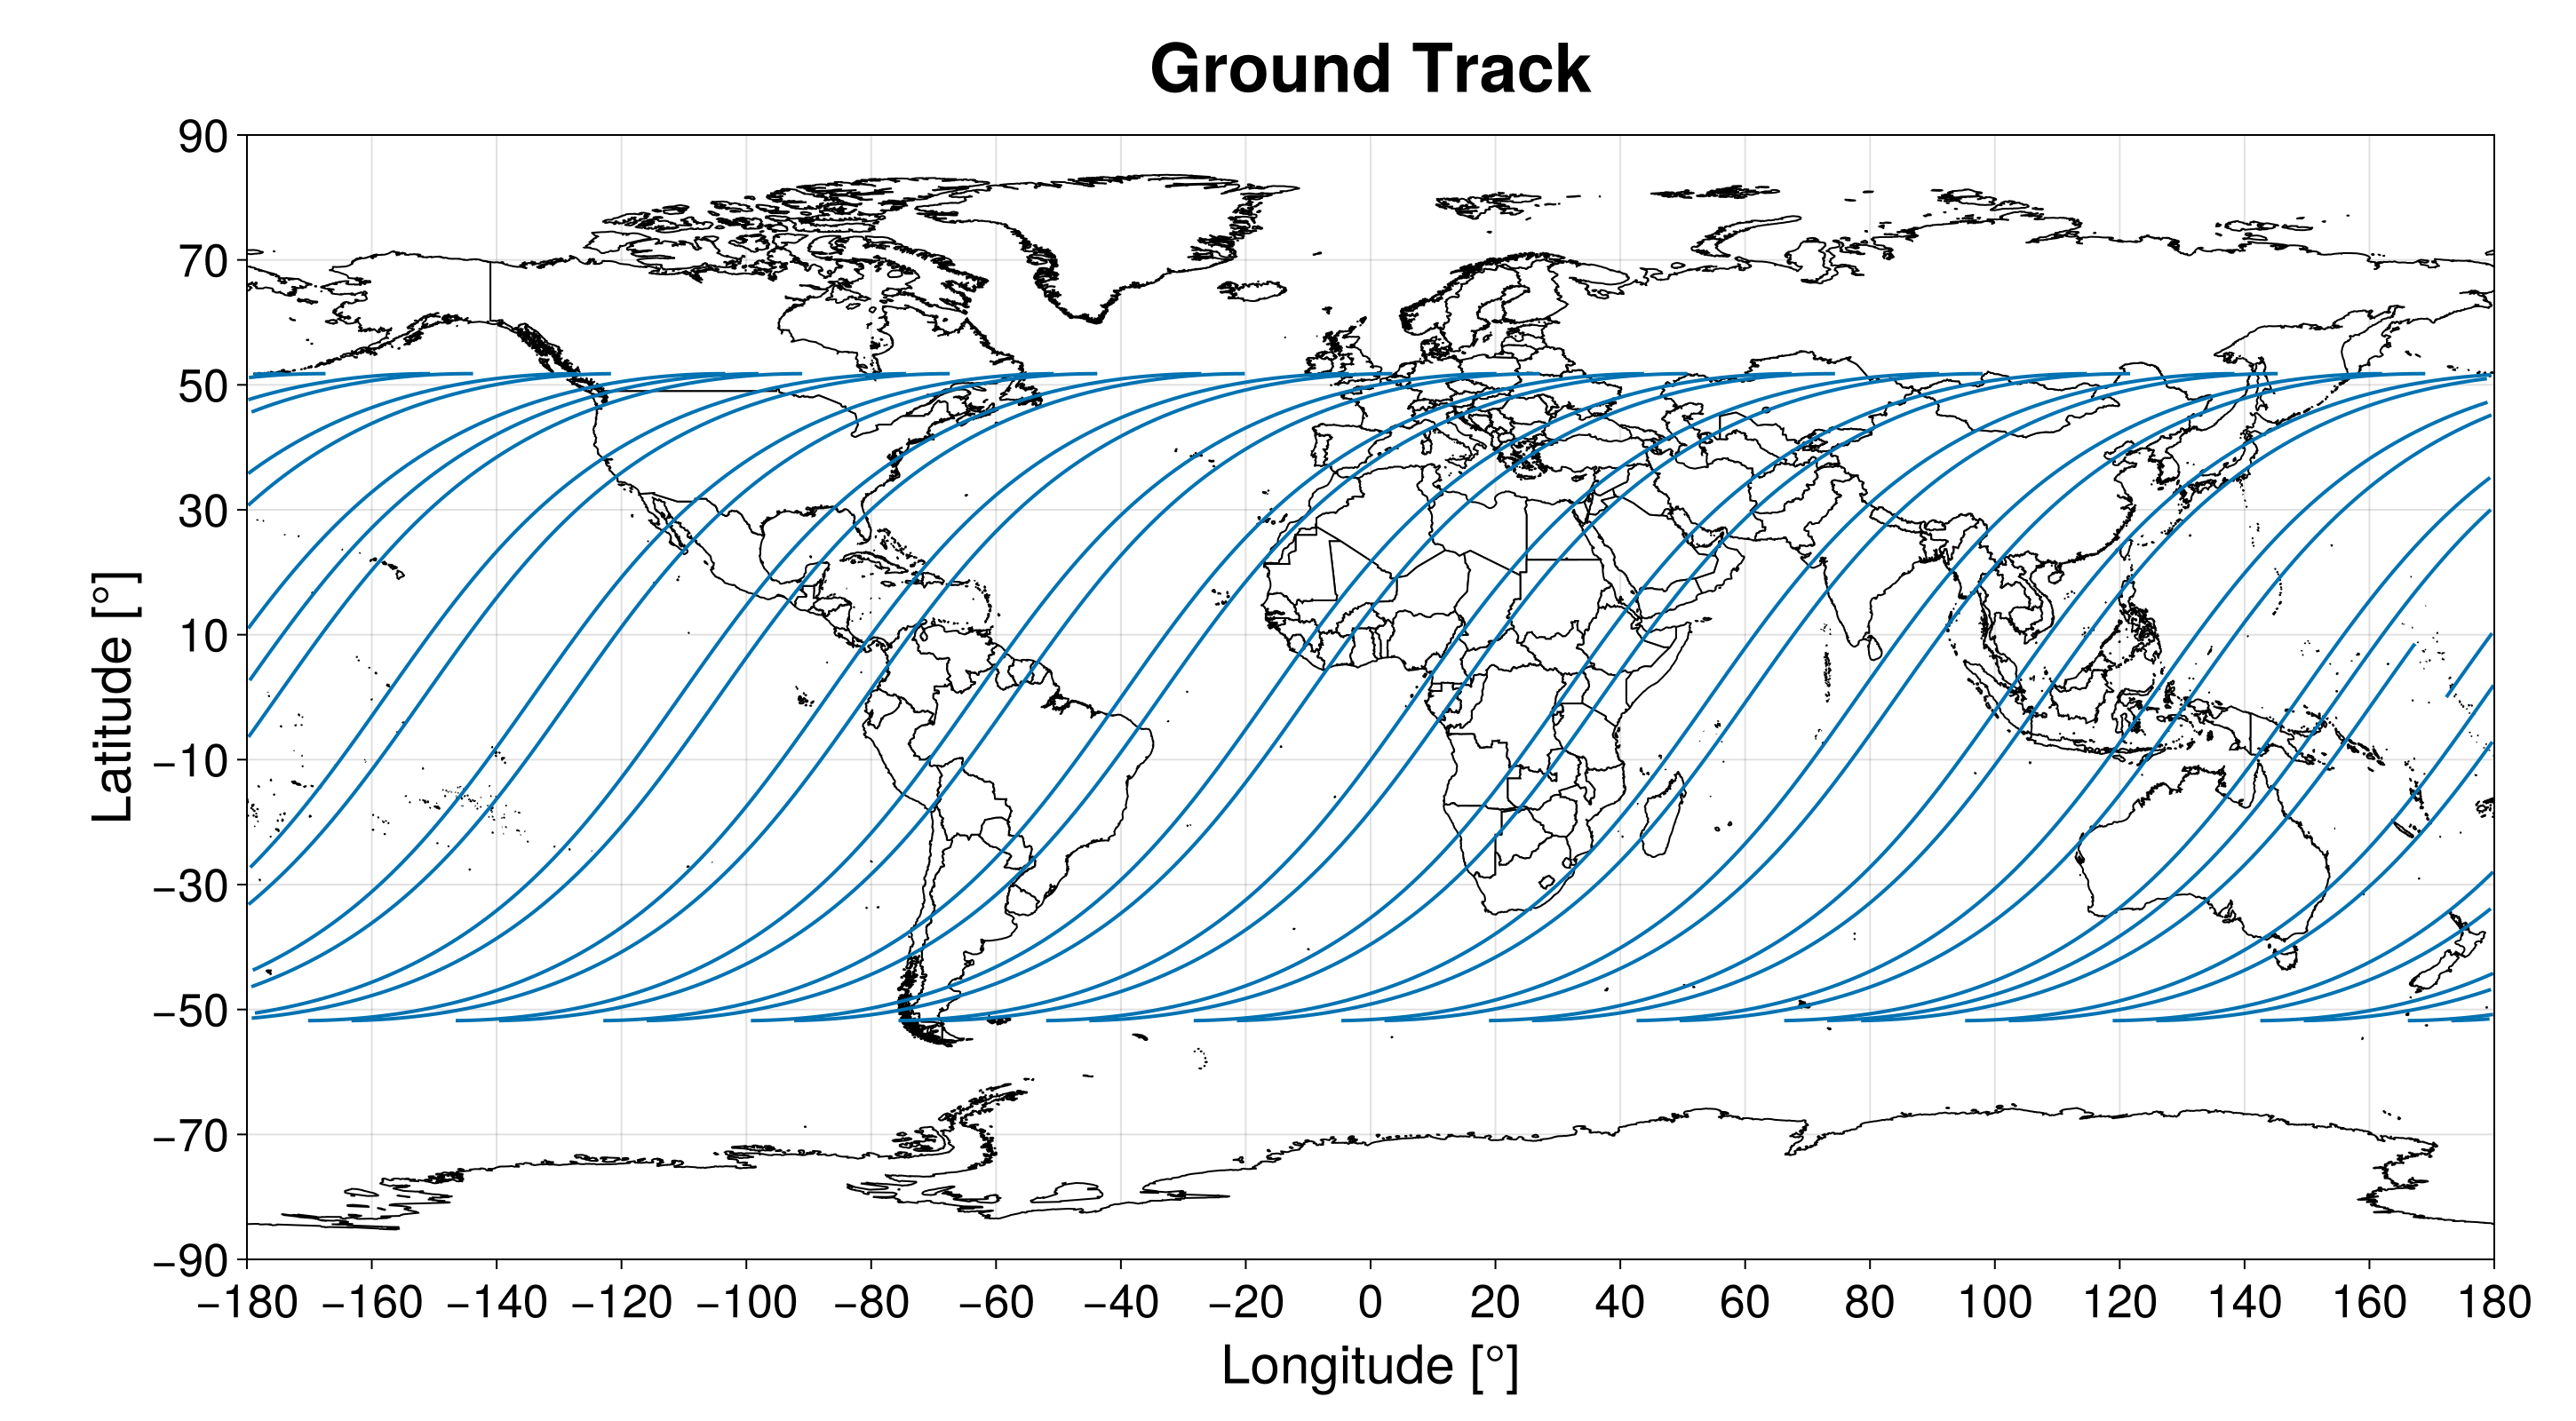

In [64]:
# Ploting the ground track
using GeoMakie, CairoMakie, SatelliteToolbox
fig, ax=plot_ground_track(gt_asc)
fig

#### GeoMakie plots the ground track on a world map, showing the ISS's path over Earth's surface.

---
### Part 2: Manual Ground Track Computation
#### For deeper understanding, we can compute the ground track manually:

###
#### 1. Orbit Propagation:
Propagates the orbit at 1-second intervals for 2 days in the TEME (True Equator, Mean Equinox) frame.

In [65]:
vt=0:1:(2*86400)
vr_teme, vv_teme=Propagators.propagate!(orbp, vt)

(StaticArraysCore.SVector{3, Float64}[[-6.652062735717167e6, 1.3725793247555634e6, 25.97836044237952], [-6.653012515913998e6, 1.3679198184952468e6, 6037.383303735144], [-6.653953820954278e6, 1.36325856965055e6, 12048.78053503802], [-6.654886649612512e6, 1.3585955841539656e6, 18060.16237457867], [-6.655811000674075e6, 1.3539308679402822e6, 24071.521142542657], [-6.656726872935228e6, 1.3492644269464794e6, 30082.84915915913], [-6.657634265203104e6, 1.3445962671118528e6, 36094.13874457372], [-6.658533176295716e6, 1.339926394377905e6, 42105.38221899097], [-6.6594236050419565e6, 1.3352548146884118e6, 48116.571902575655], [-6.660305550281606e6, 1.3305815339893259e6, 54127.700115566826]  …  [-6.494445155955093e6, 1.7078553841998863e6, 1.0106652711560284e6], [-6.494797734632022e6, 1.702974818764241e6, 1.0165664503054539e6], [-6.49514203620702e6, 1.698092083010872e6, 1.0224663302155841e6], [-6.495478060228687e6, 1.6932071831595446e6, 1.0283649033435315e6], [-6.495805806256265e6, 1.68832012543258

###
#### 2. Coordinate Transformation:
Converts positions from TEME to PEF (Pseudo-Earth Fixed) frame, accounting for Earth's rotation.

In [66]:
# First define vr_pef as the result of the map operation
vr_pef = map(
    (t, r_teme) -> begin
        jd = Propagators.epoch(orbp) + t/86400
        D_teme_pef = r_eci_to_ecef(TEME(), PEF(), jd)
        r_pef = D_teme_pef * r_teme
        r_pef
    end,
    vt, 
    vr_teme
)

172801-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [-6.731300717041844e6, 907470.8256552188, 25.97836044237952]
 [-6.731858887700606e6, 903247.520243884, 6037.383303735144]
 [-6.73240913456009e6, 899023.149874109, 12048.78053503802]
 [-6.732951457066218e6, 894797.7186288506, 18060.16237457867]
 [-6.733485852033735e6, 890571.2505561155, 24071.521142542657]
 [-6.734012324143537e6, 886343.7103991802, 30082.84915915913]
 [-6.734530870263278e6, 882115.1218568631, 36094.13874457372]
 [-6.735041489815351e6, 877885.4894843154, 42105.38221899097]
 [-6.735544182315867e6, 873654.8171958205, 48116.571902575655]
 [-6.736038947229433e6, 869423.1093739902, 54127.700115566826]
 [-6.736525784068127e6, 865190.3701108049, 60138.7591782075]
 [-6.737004692315929e6, 860956.6037915063, 66149.7414107641]
 [-6.737475669001014e6, 856721.8341941333, 72160.63913361226]
 ⋮
 [-6.551141505151038e6, 1.4835989075307727e6, 998859.0453159603]
 [-6.551227661074754e6, 1.4791903238216026e6, 1.0047628003109541e6]

###
#### Geodetic Conversion:
Transforms to WGS84 coordinates (latitude/longitude/altitude).

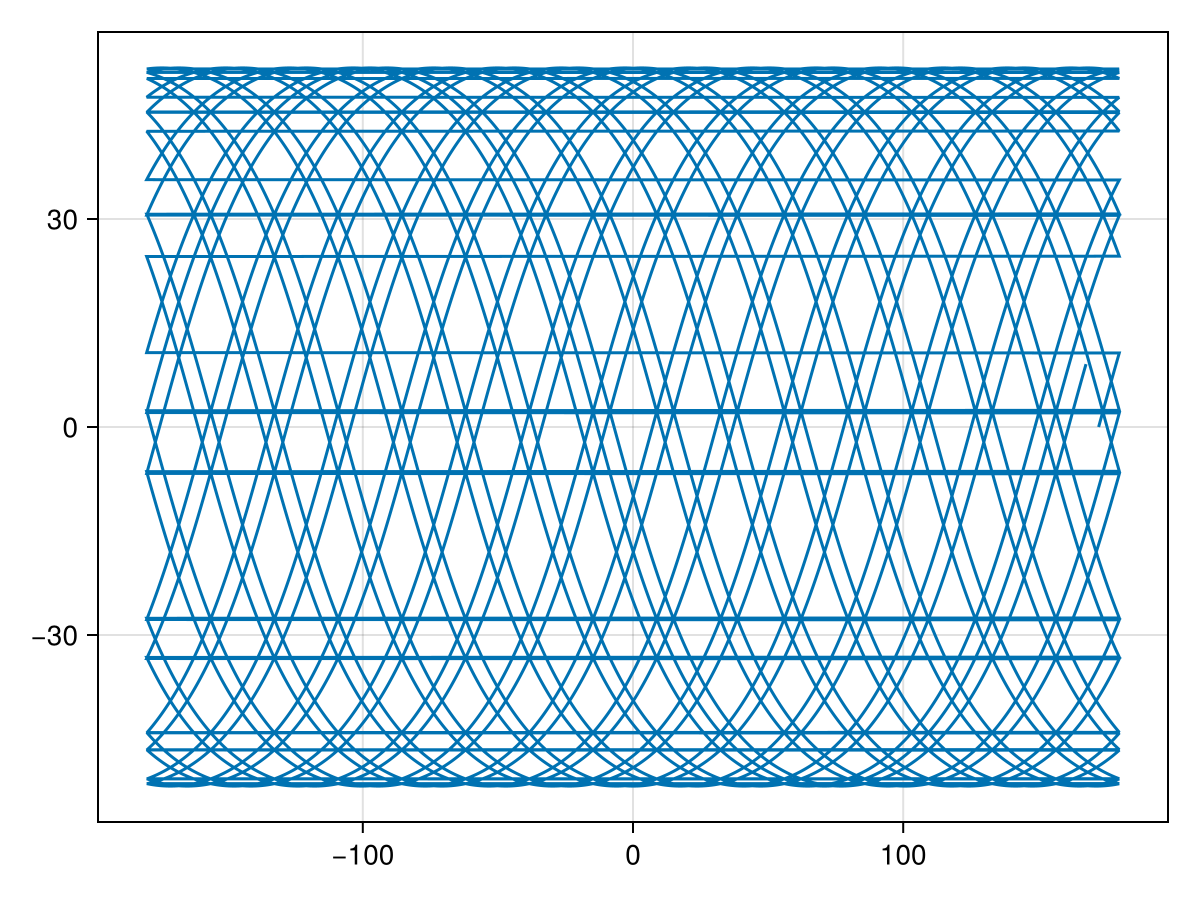

In [67]:
vwgs84=ecef_to_geodetic.(vr_pef)
lat=map(x->x[1], vwgs84)
lon=map(x->x[2], vwgs84)
h  =map(x->x[3], vwgs84)
lines(lon .|> rad2deg, lat .|> rad2deg)

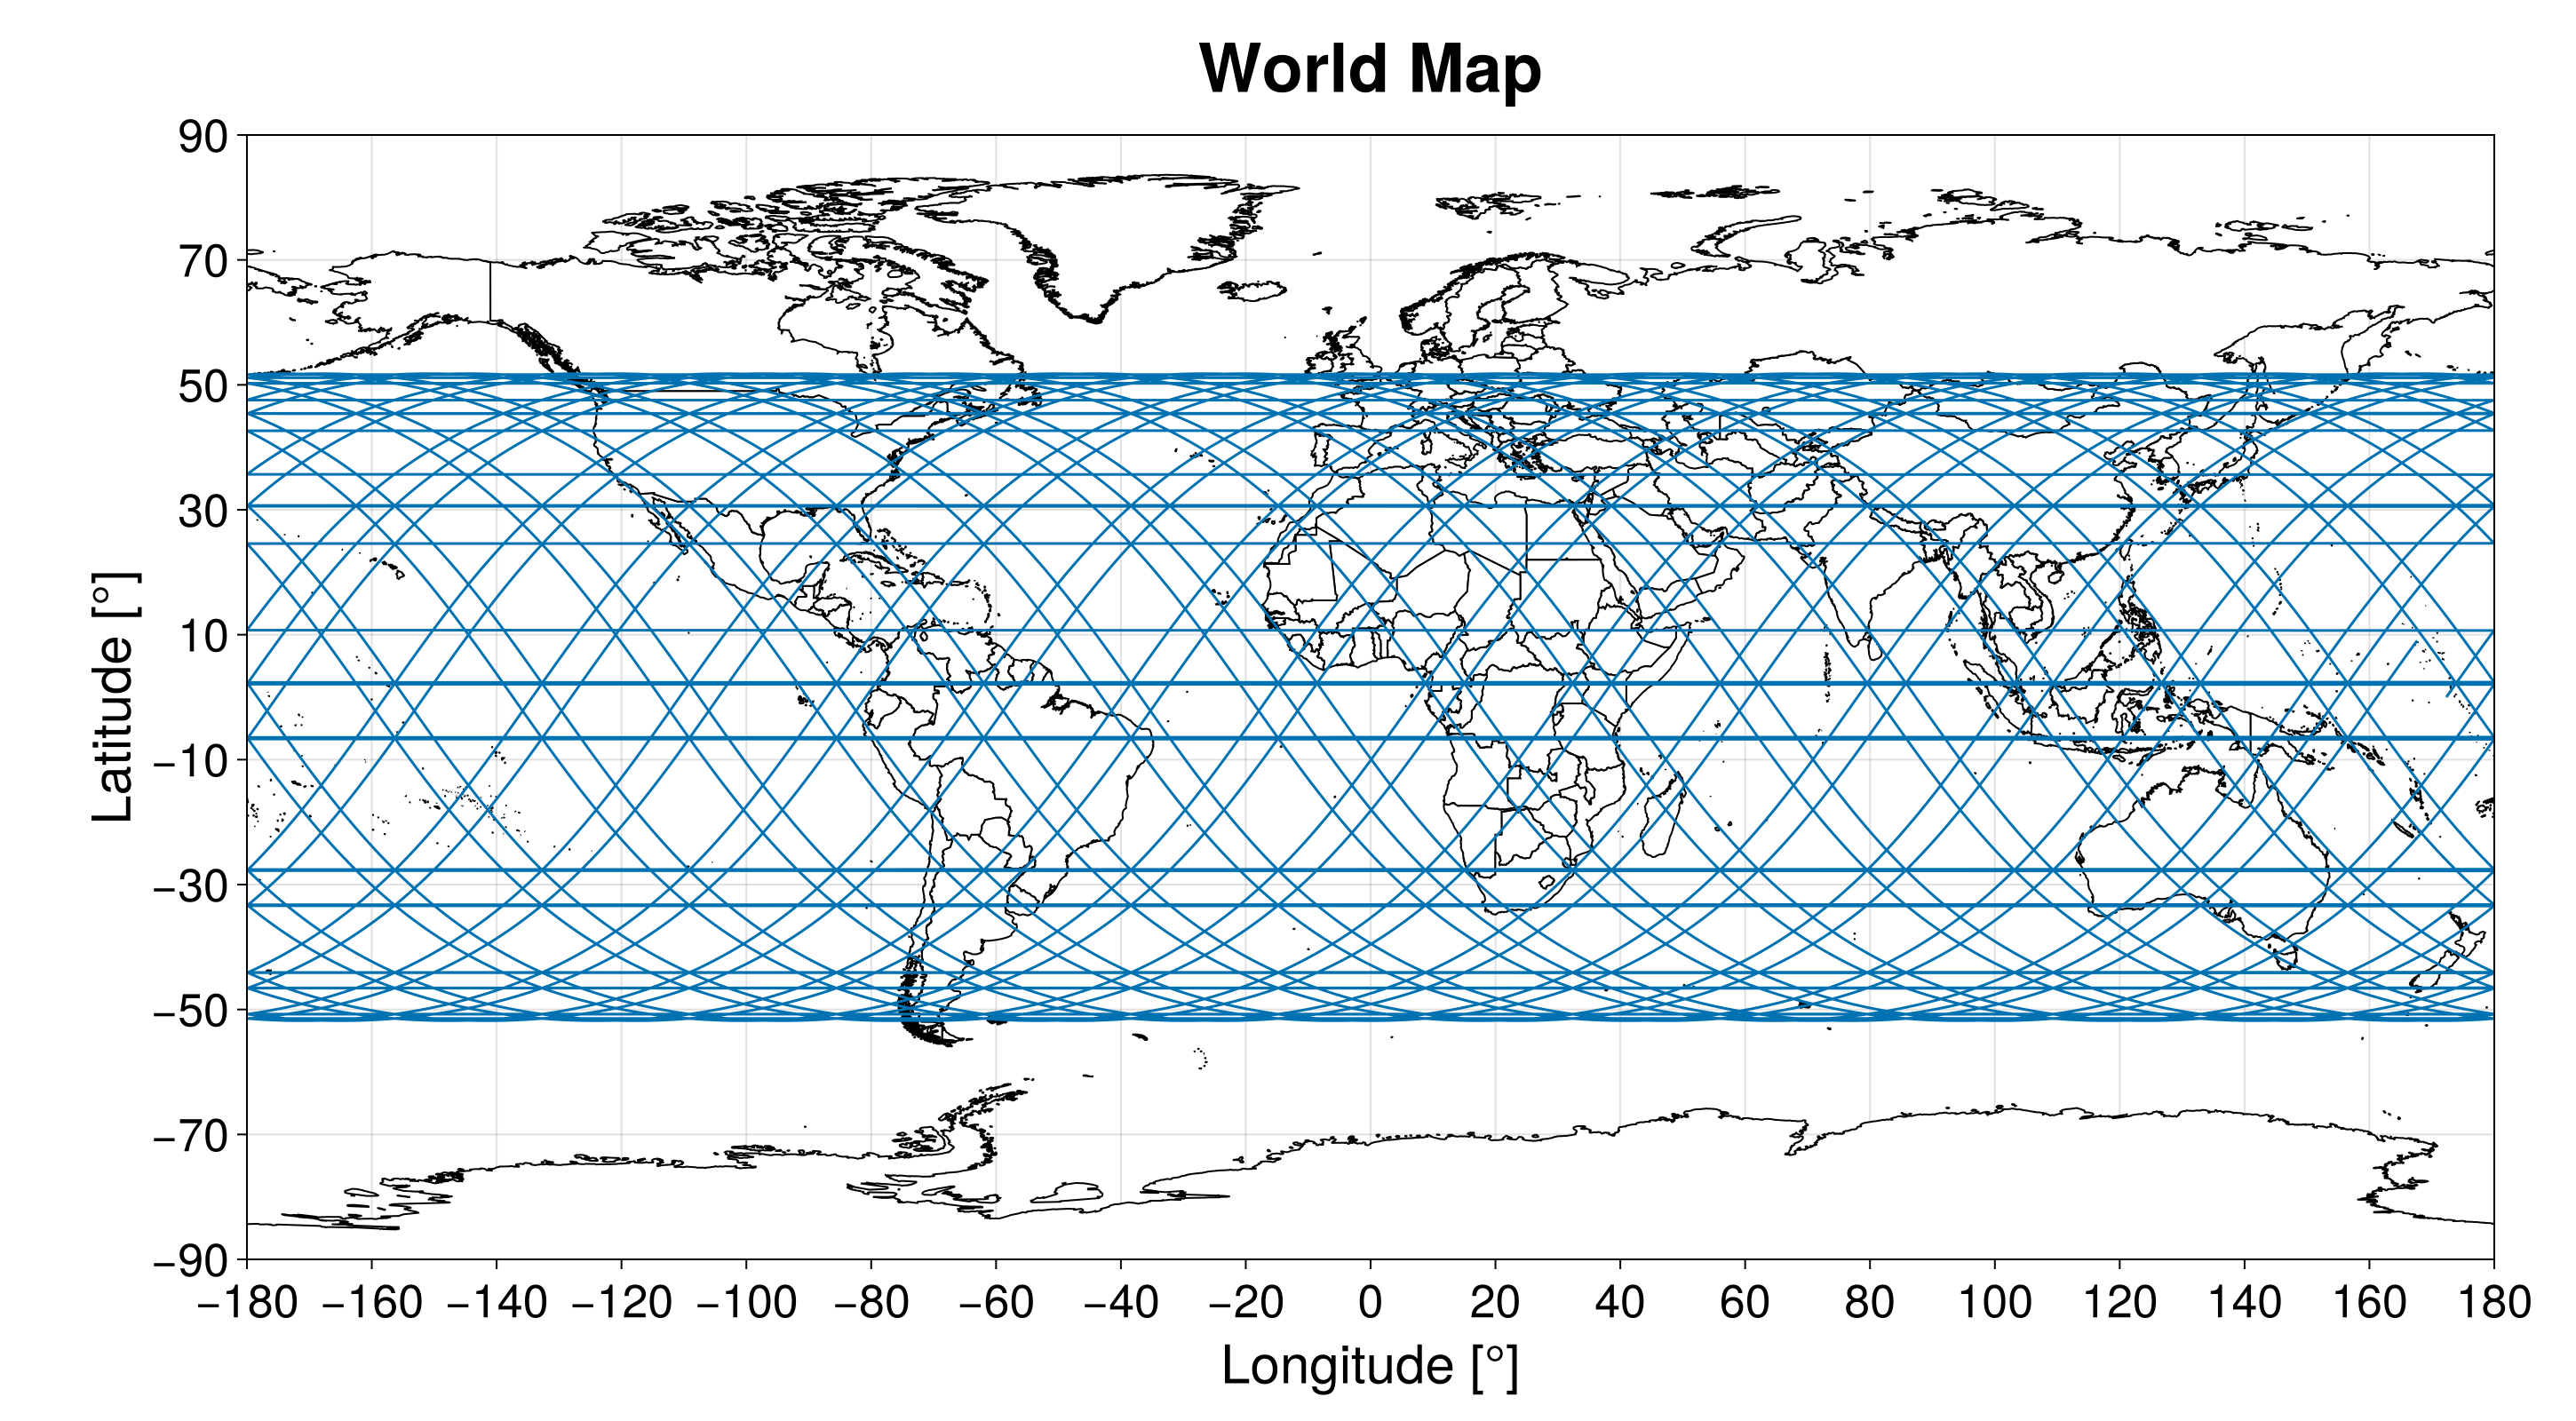

In [68]:
fig, ax=plot_world_map()

lines!(ax, lon .|> rad2deg, lat .|>rad2deg)
fig

---
### Part 3: Observation Opportunities
#### To find when the ISS is visible from a specific location (e.g., Jeddah-ksa):

###
#### 1. Local Coordinate Transformation:
Converts positions to local North-East-Down coordinates.

In [69]:
using SatelliteToolbox
using DataFrames, DataFramesMeta, Dates

In [70]:
# Fetch ISS TLE data
f = create_tle_fetcher(CelestrakTleFetcher)
tles = fetch_tles(f; satellite_name="ISS (ZARYA)")  # Corrected satellite name
iss_tle = first(tles)
orbp = Propagators.init(Val(:SGP4), iss_tle)

# Propagate orbit for 30 days at 1-minute intervals
vt = 0:60:(30*86400)  # 1-minute steps for better performance
vr_teme, vv_teme = Propagators.propagate!(orbp, vt)

# Convert to PEF frame
vr_pef = map((t, r_teme) -> begin
    jd = Propagators.epoch(orbp) + t/86400
    D_teme_pef = r_eci_to_ecef(TEME(), PEF(), jd)
    D_teme_pef * r_teme
end, vt, vr_teme)

[ Info: Fetch TLEs from Celestrak using satellite name: "ISS (ZARYA)" ...


43201-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [-6.731300717041844e6, 907470.8256552188, 25.97836044237952]
 [-6.750750980882581e6, 652331.9105756006, 360433.86430228286]
 [-6.741623606064683e6, 394259.67803378805, 719184.4060109248]
 [-6.703977762184826e6, 134182.39815102489, 1.074627606812268e6]
 [-6.637995822731902e6, -126961.10695547996, 1.4251284200375841e6]
 [-6.543982455481287e6, -388224.8034167282, 1.7690744470437472e6]
 [-6.422363140917816e6, -648658.8095952651, 2.10488352019961e6]
 [-6.273682118747316e6, -907312.8802038823, 2.431011129359795e6]
 [-6.098599801625567e6, -1.1632397134447834e6, 2.7459576519713267e6]
 [-5.897889644285762e6, -1.415498443221643e6, 3.0482753489814564e6]
 [-5.672434509913362e6, -1.663158020123736e6, 3.336575091080107e6]
 [-5.423222551202385e6, -1.905300578193244e6, 3.6095327824510993e6]
 [-5.151342633626141e6, -2.141024758211748e6, 3.865895452053419e6]
 ⋮
 [-6.288691651105577e6, 1.8052468435934505e6, 1.810714117892131e6]
 [-6.43977725780

In [71]:
# Jeddah coordinates
lat_jeddah = 39.2293 |> deg2rad
lon_jeddah = 21.4837 |> deg2rad
h_jeddah = 12  # meters above sea level

# Convert to local NED frame
vr_jeddah = ecef_to_ned.(vr_pef, lat_jeddah, lon_jeddah, h_jeddah, translate=true)

43201-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [3.772053766753926e6, 3.309669522844431e6, 1.0964077867788477e7]
 [4.1217741421879376e6, 3.0793805983280735e6, 1.0822548036120594e7]
 [4.454072578442688e6, 2.8358959830858666e6, 1.0662299701466445e7]
 [4.767490770175743e6, 2.5801011227650912e6, 1.048415566818774e7]
 [5.060652052342085e6, 2.312936403639831e6, 1.0289015097935947e7]
 [5.33226760161204e6, 2.0353937113101275e6, 1.0077848933191499e7]
 [5.581142217582985e6, 1.748512757834553e6, 9.851694988010013e6]
 [5.806179674016829e6, 1.4533770876193584e6, 9.61165275959796e6]
 [6.006387563440854e6, 1.1511100528664894e6, 9.358877929837128e6]
 [6.180881682709087e6, 842870.4173542949, 9.094576674876759e6]
 [6.3288898880501045e6, 529847.87959188, 8.819999751329174e6]
 [6.449755426902831e6, 213258.43146113656, 8.536436419916768e6]
 [6.542939732742885e6, -105660.4103391578, 8.245208237073563e6]
 ⋮
 [4.70624155907824e6, 3.982970071832451e6, 9.245224866022652e6]
 [4.583722684409839e6, 3.

###
#### 2. Elevation Calculation:
Computes elevation angles from the horizon.

In [72]:
# Calculate observation times and elevations
vdt = julian2datetime.(Propagators.epoch(orbp) .+ vt./86400) .+ Dates.Hour(2)  # UTC+2
velev = map(r_ned -> atand(-r_ned[3], sqrt(r_ned[1]^2 + r_ned[2]^2)), vr_jeddah)

43201-element Vector{Float64}:
 -65.40669531201465
 -64.57351115381167
 -63.654170321753
 -62.658591540040625
 -61.59607875930084
 -60.475207915440244
 -59.30378742094504
 -58.088870417086575
 -56.83679993650979
 -55.553273298640946
 -54.243415439337674
 -52.911854771496394
 -51.56279759830245
   ⋮
 -56.30149970109049
 -58.236864871385706
 -60.1688587708723
 -62.09751515985343
 -64.02278172019037
 -65.94450017035372
 -67.86237349788328
 -69.77591263595897
 -71.68434749711363
 -73.58647550268888
 -75.48039116636899
 -77.36297675172243

###
#### 3. Optimal Pass Filtering:
Filters for evening passes with elevation >30°.

In [73]:
# Create and filter DataFrame
df = DataFrame(time=vdt, elevation=velev, lon=lon_jeddah, lat=lat_jeddah)

# Filter for evening passes with elevation >30°
results = @chain df begin
    @subset(:elevation .>= 30)
    @subset(Time("18:00") .<= Time.(:time) .<= Time("20:00"))
    @transform(:day = Date.(:time))
    @transform(:hour = Time.(:time))
    @groupby(:day)
    @combine(:time = minimum(:hour), :max_elevation = maximum(:elevation))
end

5×3 DataFrame
 Row │ day         time          max_elevation 
     │ Date        Time          Float64       
─────┼─────────────────────────────────────────
   1 │ 2025-07-15  18:45:59.192        62.3193
   2 │ 2025-07-28  19:29:59.192        36.7256
   3 │ 2025-07-30  19:26:59.192        66.2757
   4 │ 2025-07-31  18:37:59.192        53.318
   5 │ 2025-08-02  18:36:59.192        46.525

---
###
#### Conclusion
The SatelliteToolbox.jl ecosystem provides powerful tools for satellite tracking and 
visualization. By combining orbit propagation, coordinate transformations, and geometric 
calculations, we can accurately predict ISS passes and plan observations. This approach can be
extended to other satellites and customized for specific observation needs.